Install keras

In [1]:
!pip3 install keras
!pip3 install pillow

Download data and uncompress

In [2]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz
!git clone https://github.com/Donny-Hikari/Viola-Jones

--2021-06-08 20:16:13--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2021-06-08 20:16:14--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfcbe2ef7edef3359aa6ce6b581.dl.dropboxusercontent.com/cd/0/inline/BQAIbe0P85wXI0JZIMEwdh9iNpKTCeZDD45hj5L0agKa2TzD1dOwk9TOP2uwgcuvACv7O2eSHTFPMQtZidCc4oAIA1hMtebFNuTZ1SjAETYzKkpXGvWMCvPXgr5erJYcvzRz_cxeMHuwW7Fpa-cfbadp/file# [following]
--2021-06-08 20:16:14--  https://ucfcbe2ef7edef3359aa6ce6b581.dl.dropboxusercontent.com/cd/0/inline/BQAIbe0P85wXI0JZIMEwdh9iNpKTCeZDD45hj5L0agKa2TzD1dOwk9TOP2uwgcuvACv7O2eSHTFPMQtZidCc4oAIA1hMtebF

Import packages 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageOps, Image

from __future__ import print_function

import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Define batch size, number of epochs and number of classes

In [4]:
batch_size = 128
epochs = 50
num_classes=2

Load and prepare data

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


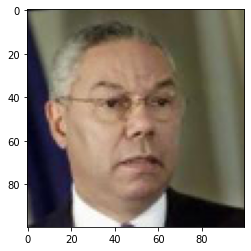

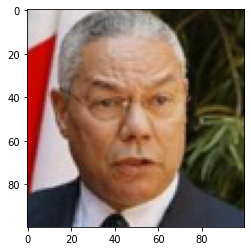

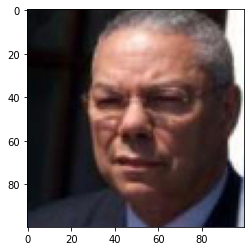

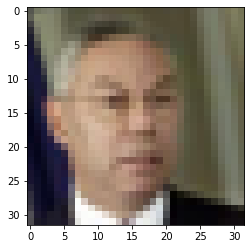

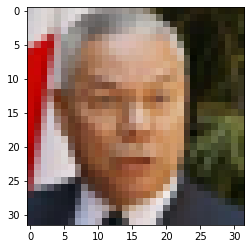

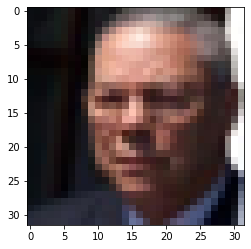

(10585, 32, 32, 3)
(2648, 32, 32, 3)


In [5]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
for i in range(3):
  plt.imshow(x_train[i,:,:,:])
  plt.show()

x_train.astype('float32')
x_test.astype('float32')

## Transforms
x_train = [np.array(Image.fromarray(x, 'RGB').resize((32, 32))) for x in x_train]
x_test = [np.array(Image.fromarray(x, 'RGB').resize((32, 32))) for x in x_test]

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## View some proccesed images
for i in range(3):
  plt.imshow(x_train[i])
  plt.show()

x_train = np.array([x / 255 for x in x_train])
x_test = np.array([x / 255 for x in x_test])

x_train = np.array(x_train).astype('float32').astype('float32')
x_test = np.array(x_test).astype('float32').astype('float32')

print(x_train.shape)
print(x_test.shape)

num_classes = 2

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

Create model, data augmentation etc... 

Data Augmentation with ImageGenerator

In [6]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=45,
    vertical_flip=False)

Define a convolutional block. Batch norm + Gaussian Norm

In [7]:
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.25))
  model.add(Activation('relu'))
  #model.add(Dropout(0.25))
  
  return model

Define the NN topology

In [8]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,32)
model.add(MaxPooling2D(pool_size=(2, 2)))
model=CBGN(model,32)
model=CBGN(model,32)
model.add(MaxPooling2D(pool_size=(2, 2)))
model=CBGN(model,64)
model=CBGN(model,64)
model.add(MaxPooling2D(pool_size=(2, 2)))
model=CBGN(model,64)
model=CBGN(model,64)
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(BN())
model.add(GN(0.2))
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0

Define an optimizer

In [9]:
sgd=SGD(lr=0.1, decay=0.0, momentum=0.0)

def scheduler(epoch):
  if epoch < epochs / 3:
    return 0.1
  elif epoch < epochs / 3 * 2:
    return 0.05
  else:
    return 0.02
set_lr = LRS(scheduler)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Compile the model, define loss and link the optimizer

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Model training and evaluation

In [11]:
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
82/82 [==============================] - 54s 83ms/step - loss: 0.7013 - accuracy: 0.7172 - val_loss: 0.5438 - val_accuracy: 0.7749
Epoch 2/50
82/82 [==============================] - 5s 64ms/step - loss: 0.5109 - accuracy: 0.7677 - val_loss: 0.6433 - val_accuracy: 0.7606
Epoch 3/50
82/82 [==============================] - 5s 65ms/step - loss: 0.4729 - accuracy: 0.7766 - val_loss: 0.7038 - val_accuracy: 0.4777
Epoch 4/50
82/82 [==============================] - 5s 65ms/step - loss: 0.4249 - accuracy: 0.8051 - val_loss: 0.5009 - val_accuracy: 0.7870
Epoch 5/50
82/82 [==============================] - 5s 65ms/step - loss: 0.4042 - accuracy: 0.8134 - val_loss: 0.3911 - val_accuracy: 0.8229
Epoch 6/50
82/82 [==============================] - 5s 65ms/step - loss: 0.4175 - accuracy: 0.8121 - val_loss: 0.4466 - val_accuracy: 0.7647
Epoch 7/50
82/82 [==============================] - 5s 66ms/step - loss: 0.3815 - accuracy: 0.8332 - val_loss: 0.4950 - val_accuracy: 0.7413
Epoch 8/50
8

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [13]:
import matplotlib.pyplot as plt

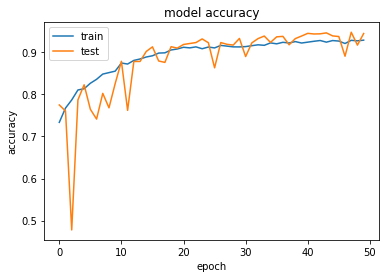

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()